In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2025-11-01 19:05:27.953756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762023927.976093    1449 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762023927.983025    1449 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGE_SIZE = 255
BATCH_SIZE = 32
CHANNEL = 3

<h1>Splitting the Dataset</h1>

<h3>Dataset should be bifurcated into 3 subsets, namely:</h3>

<p>Training: Dataset to be used while training</p>
<p>Validation: Dataset to be tested against while training</p>
<p>Test: Dataset to be tested against after we trained a model</p>

In [3]:
DATA_DIR = "/kaggle/input/potato-leaf-disease-dataset/Potato"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{DATA_DIR}/Train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 900 files belonging to 3 classes.


I0000 00:00:1762023939.803363    1449 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762023939.804039    1449 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{DATA_DIR}/Valid",
    seed=123,
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 300 files belonging to 3 classes.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{DATA_DIR}/Test",
    seed=123,
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 300 files belonging to 3 classes.


In [6]:
class_name = train_ds.class_names

In [7]:
for batch_size, label_size in train_ds.take(1):
    print('Image shape :',batch_size.shape)
    print('Label :',label_size.numpy)
    print('Image :',batch_size[0])

Image shape : (32, 255, 255, 3)
Label : <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 2, 2, 2, 0, 1, 2, 1, 0, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2,
       1, 0, 2, 0, 0, 0, 1, 2, 0, 2], dtype=int32)>>
Image : tf.Tensor(
[[[146.89827  134.89827  138.89827 ]
  [117.32479  105.32479  109.32479 ]
  [159.80559  147.80559  151.80559 ]
  ...
  [189.00586  179.00586  178.00586 ]
  [188.99608  178.99608  177.99608 ]
  [188.99413  178.99413  177.99413 ]]

 [[125.09177  113.09177  117.09177 ]
  [153.73062  141.73062  145.73062 ]
  [135.74919  123.74919  127.74919 ]
  ...
  [187.0177   177.0177   176.0177  ]
  [187.01765  177.01765  176.01765 ]
  [186.02547  176.02547  175.02547 ]]

 [[131.32344  119.323456 123.323456]
  [126.39447  114.39447  118.39447 ]
  [143.41678  131.41678  135.41678 ]
  ...
  [190.0195   180.0195   179.0195  ]
  [190.00006  180.00006  179.00006 ]
  [190.       180.       179.      ]]

 ...

 [[133.22902  120.22902  127.22902

<h1>Visualize Some of Images from Dataset</h1

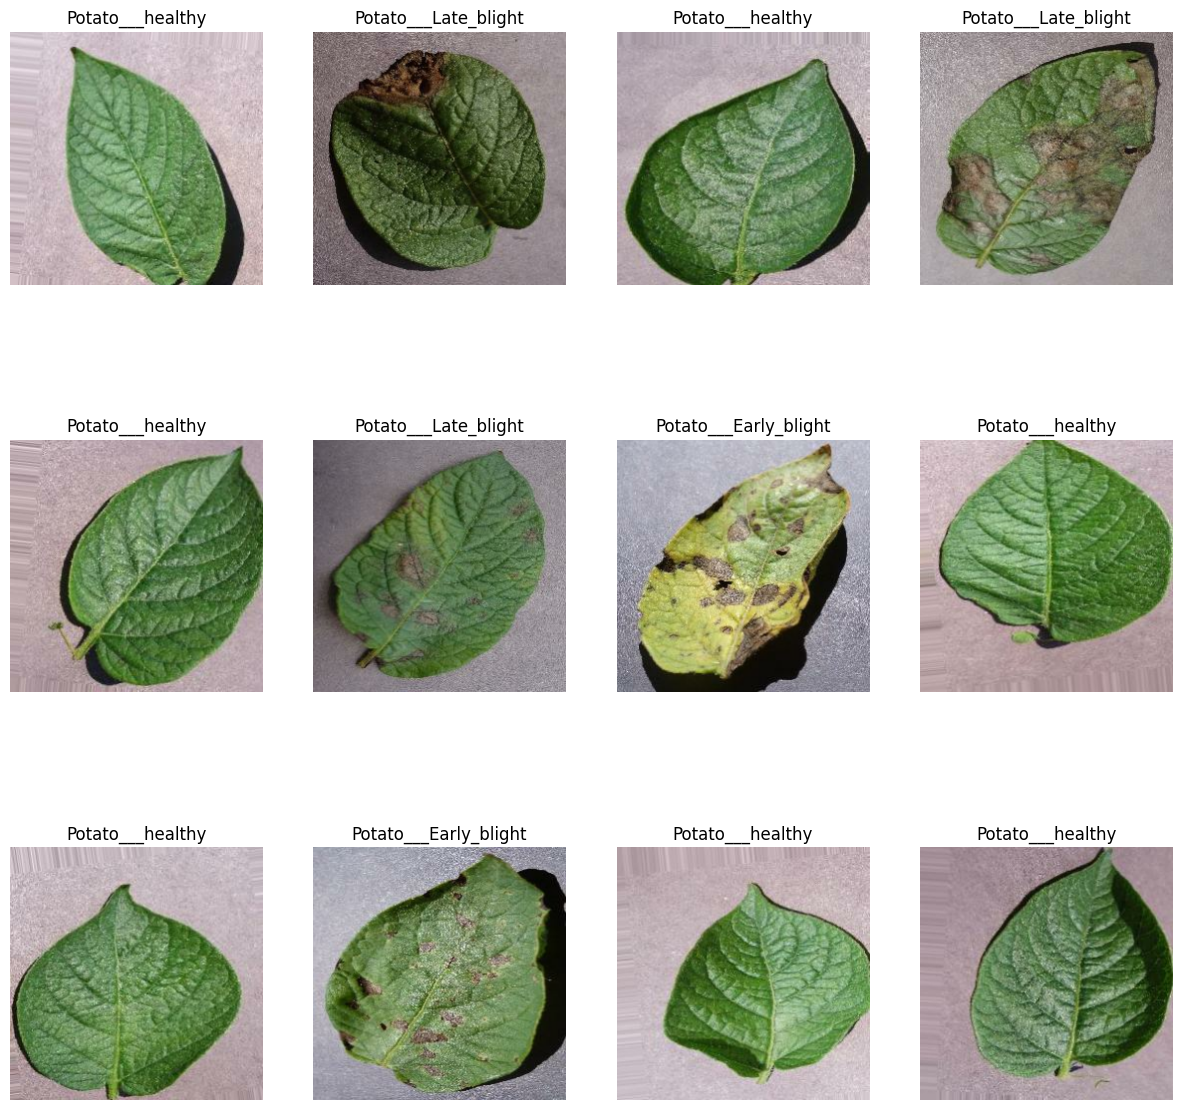

In [8]:
plt.figure(figsize=(15,15))
for img, label in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_name[label[i]])
        plt.axis('off')

In [9]:
len(train_ds),len(val_ds),len(test_ds)

(29, 10, 10)

<h1>Cache, Shuffle and Prefetch</h1>

<h4>cache() → keeps data in memory for faster reuse</h4>

<h4>shuffle(1000) → randomizes training samples each epoch</h4>

<h4>prefetch(AUTOTUNE) → loads next batch while training the current one</h4>

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<h1>Building the Model</h1>

<h4>Creating a Layer for Resizing and Normalization Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.</h4>

<h4>You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it</h4>

In [11]:
from tensorflow import keras

In [12]:
resize_and_rescale = keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

<h1>Data Augmentation</h1>

<h4>Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.</h4>

In [13]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

<h1>Applying Data Augmentation to Train Dataset</h1>

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


<h1>Model Architecture</h1>

<h4>We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.</h4>

In [15]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3

model = tf.keras.Sequential([
    resize_and_rescale,  # normalization layer
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',      # what to monitor
    patience=3,              # stop after 3 epochs with no improvement
    restore_best_weights=True  # revert to best model
)

<h1>Compiling the Model</h1>

<h4>We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric</h4>

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=70,
    callbacks=[early_stopping]
)

Epoch 1/70


I0000 00:00:1762023986.362888    1509 service.cc:148] XLA service 0x78a510013a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762023986.362931    1509 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762023986.362937    1509 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762023986.693487    1509 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/29 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5469 - loss: 1.0891 

I0000 00:00:1762023992.181879    1509 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 495ms/step - accuracy: 0.3440 - loss: 1.1030 - val_accuracy: 0.3333 - val_loss: 1.0855
Epoch 2/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.3765 - loss: 1.0568 - val_accuracy: 0.6667 - val_loss: 0.8252
Epoch 3/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.5352 - loss: 0.9394 - val_accuracy: 0.5900 - val_loss: 0.8590
Epoch 4/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - accuracy: 0.6236 - loss: 0.7806 - val_accuracy: 0.6533 - val_loss: 0.7272
Epoch 5/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.7290 - loss: 0.6190 - val_accuracy: 0.8067 - val_loss: 0.4748
Epoch 6/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 301ms/step - accuracy: 0.7421 - loss: 0.5922 - val_accuracy: 0.8267 - val_loss: 0.4122
Epoch 7/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.8065 - loss: 0.4437 - val_accuracy: 0.7800 - val_loss: 0.5456
Epoch 8/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 298ms/step - accuracy: 0.7688 - loss: 0.5118 - val_accuracy: 0.8233 - val

In [19]:
score = model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9705 - loss: 0.0893


In [28]:
model.save('Crop_Disease_Classification.h5')

<h1>Plotting the Accuracy and Loss Curves</h1>

In [21]:
print(history)
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 70, 'steps': 29}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [23]:
history.history['loss'][:10] # show loss for first 5 epochs

[1.1004685163497925,
 1.0295723676681519,
 0.9370003342628479,
 0.7369043231010437,
 0.5744066834449768,
 0.5775447487831116,
 0.49065470695495605,
 0.47358083724975586,
 0.39211511611938477,
 0.41300031542778015]

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

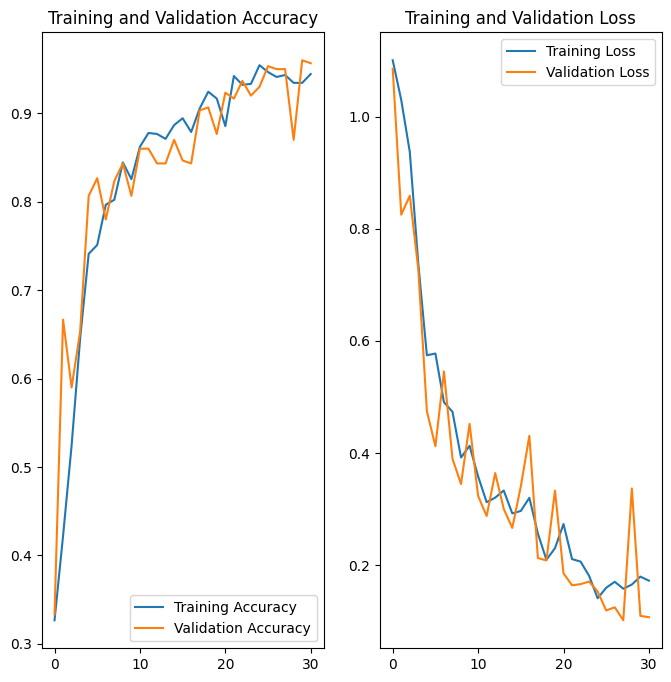

In [27]:
#as we used early stopping, our training might have stopped before 70 epochs — in that case, replace range(70) with :
epochs_range = range(len(acc))   


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h1>Run prediction on a sample image</h1>

In [29]:
model1 = tf.keras.models.load_model('Crop_Disease_Classification.h5')

first image to predict
actual label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
predicted label: Potato___healthy


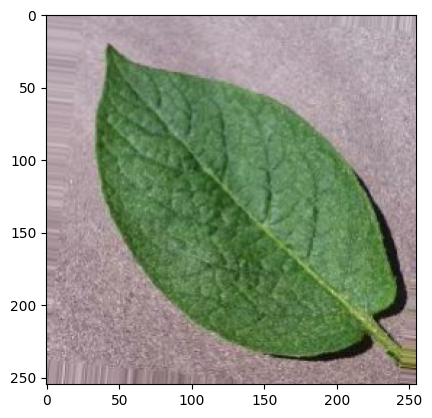

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

<h1>For Multiple Images</h1>

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

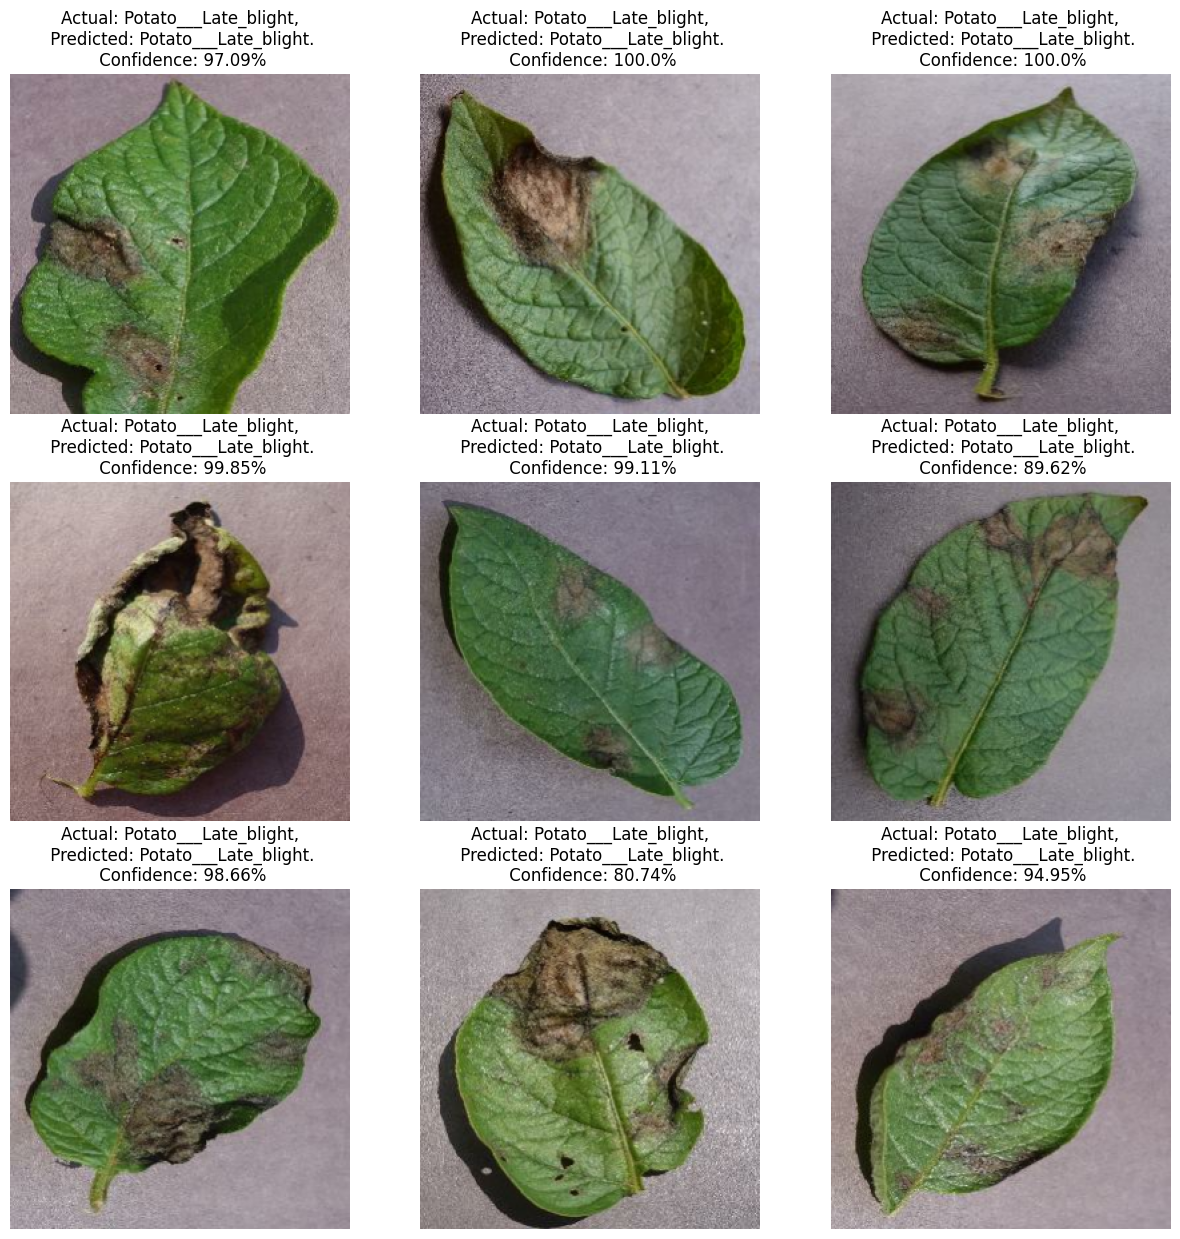

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(3):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")